In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from matplotlib import pyplot as plt
import statsmodels.api as sm

from IPython.display import clear_output

from datetime import date, timedelta

# Download data

In [ ]:
ticker_symbol = 'MSFT'

df = yf.download(ticker_symbol)
print(len(df))
df.head()

[*********************100%***********************]  1 of 1 completed
9425


Open      High       Low     Close  Adj Close      Volume
Date                                                                     
1986-03-13  0.088542  0.101563  0.088542  0.097222   0.060524  1031788800
1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062686   308160000
1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063767   133171200
1986-03-18  0.102431  0.103299  0.098958  0.099826   0.062145    67766400
1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061065    47894400

In [ ]:
df.last('3D')

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-02  333.630005  333.630005  326.359985  327.500000  327.500000   
2023-08-03  326.000000  329.880005  325.950012  326.660004  326.660004   
2023-08-04  331.880005  335.140015  327.239990  327.779999  327.779999   

              Volume  
Date                  
2023-08-02  27761300  
2023-08-03  18253700  
2023-08-04  23727700

In [ ]:
# Create a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

# Add title and axis labels
fig.update_layout(title=f'{ticker_symbol} Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price')

# Show the plot
fig.show()

<Axes: title={'center': 'Differences'}, xlabel='Date'>

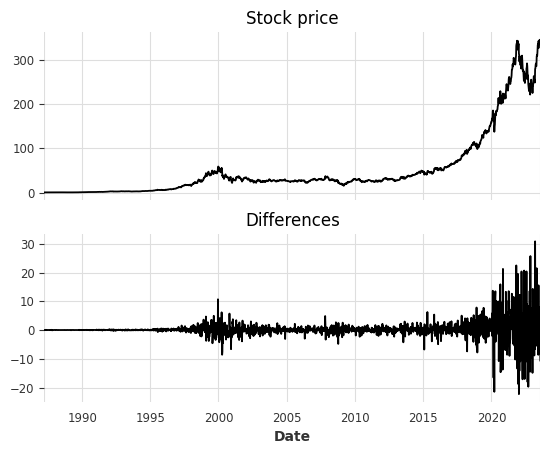

In [ ]:
df_weekly = df.resample('w').last()
len(df_weekly)
df_diff = df_weekly.diff().dropna()
fig, ax = plt.subplots(2,sharex=True)
df_weekly.Close.plot(title="Stock price", ax=ax[0])
df_diff.Close.plot(title="Differences", ax=ax[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



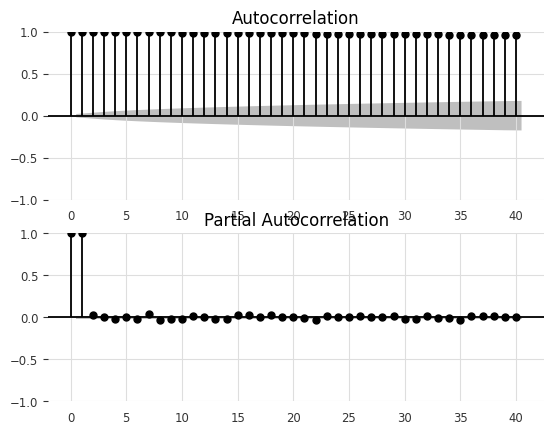

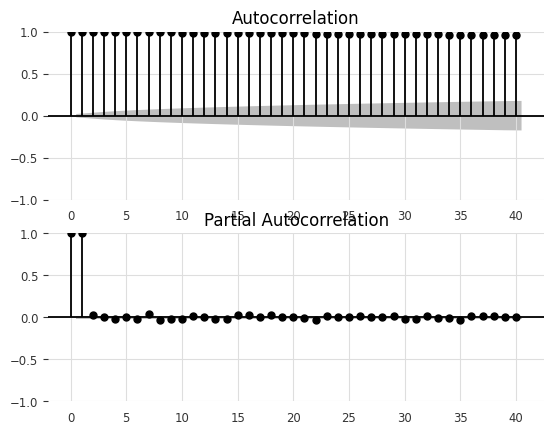

In [ ]:
#Test stationary
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
n_lags = 40
sign_level=0.05
fig, ax = plt.subplots(2,1)
plot_acf(df.Close, ax=ax[0], lags=n_lags, alpha=sign_level)
plot_pacf(df.Close, ax=ax[1], lags=n_lags, alpha=sign_level)

# Leverage effect

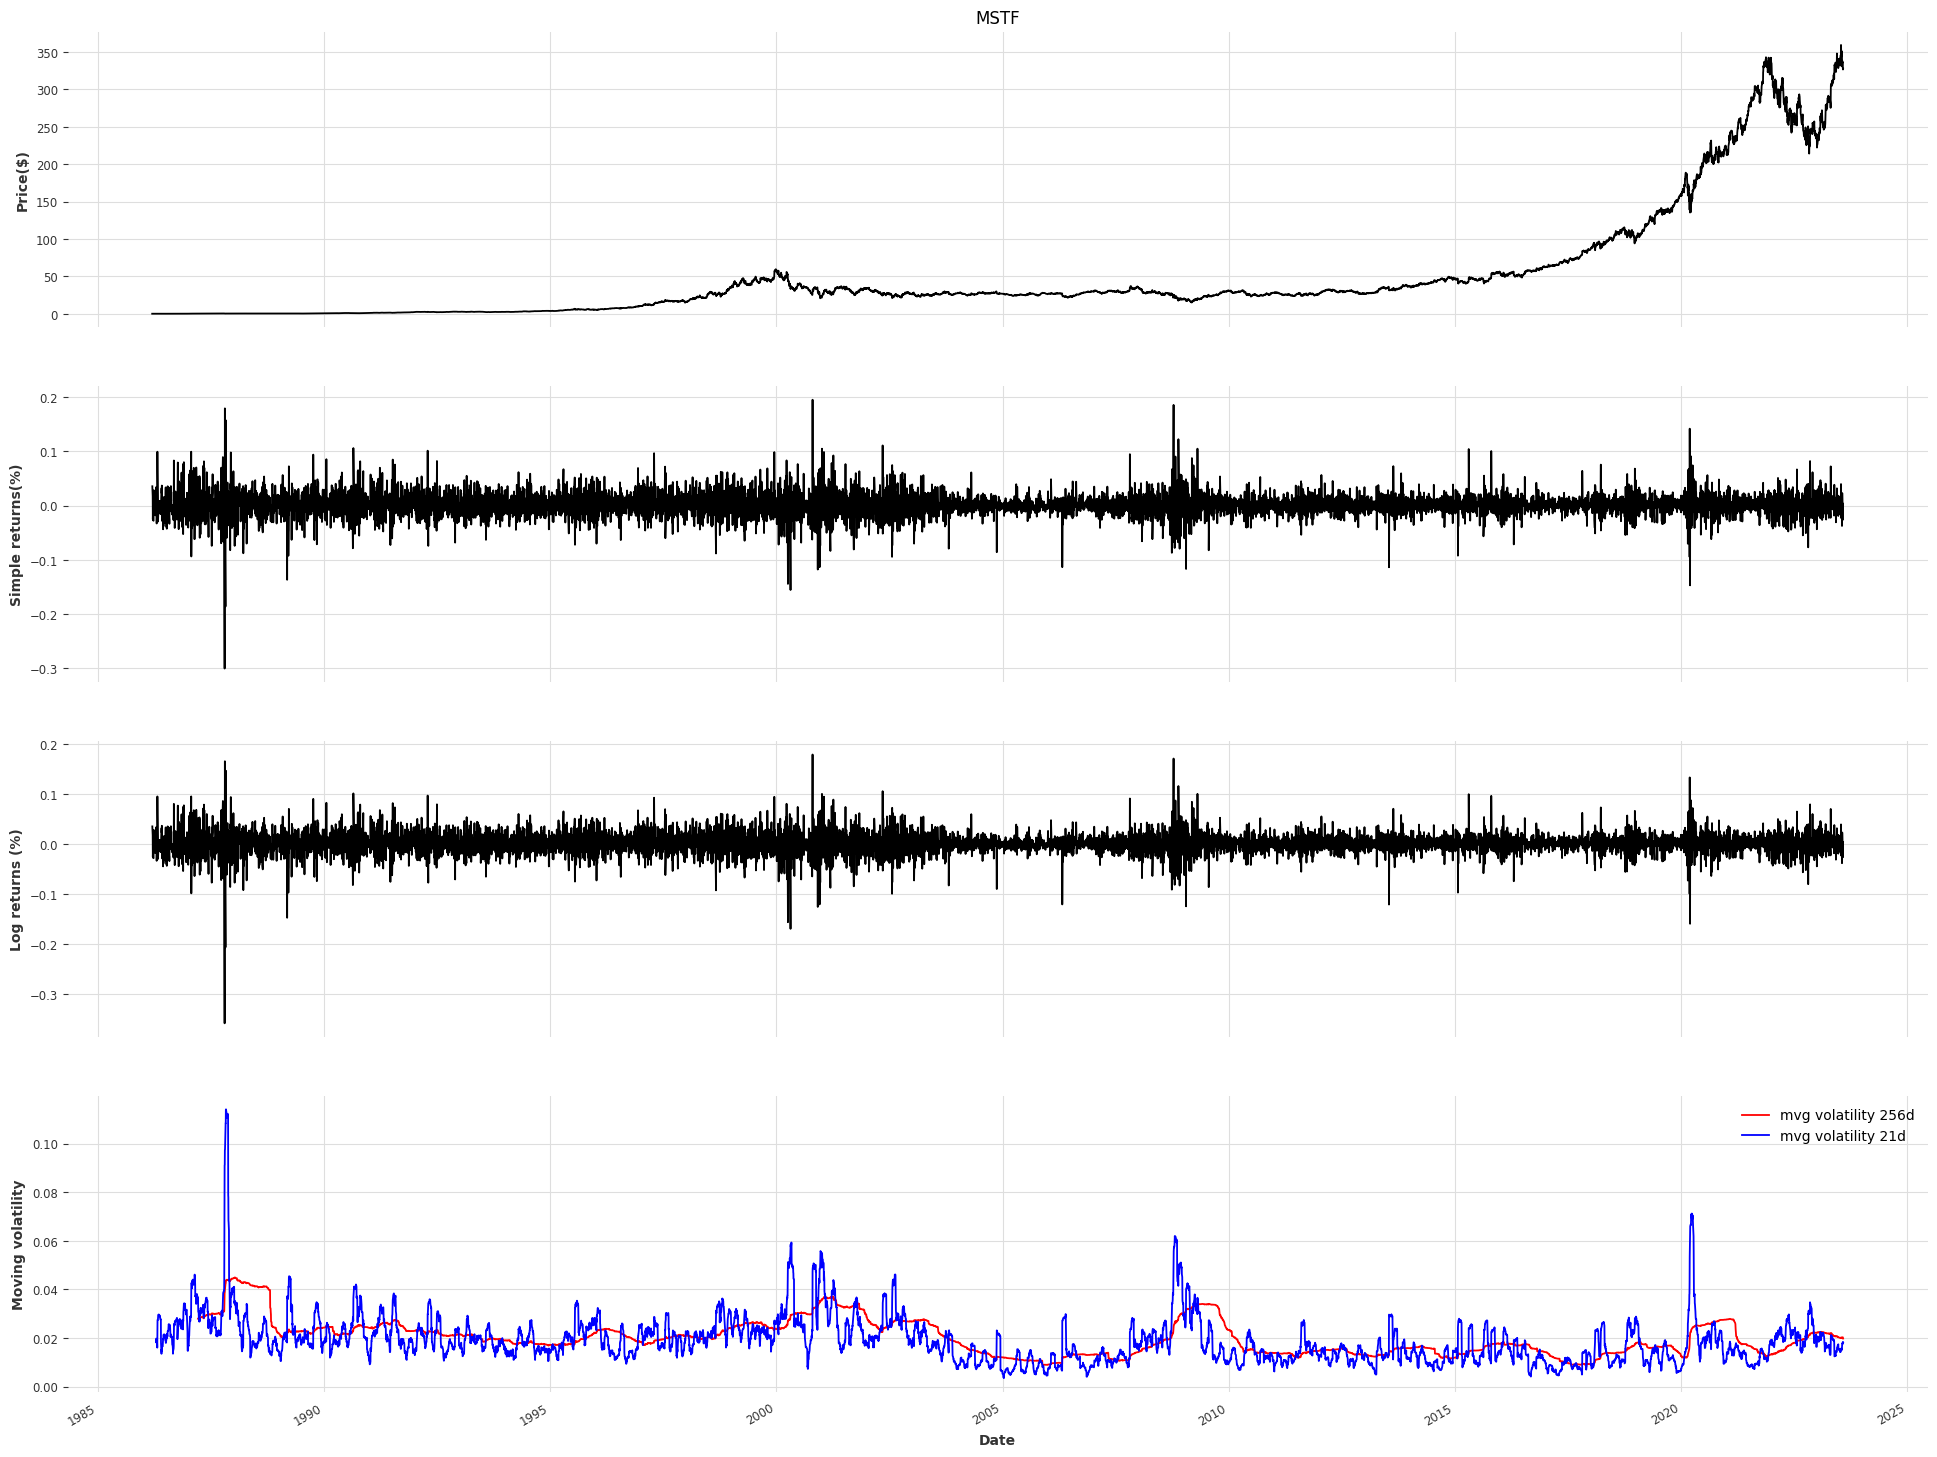

In [ ]:
df['simple_return'] = df.Close.pct_change()
df['log_return']=np.log(df.Close/df.Close.shift(1))
df['mvg_std_256']=df[['log_return']].rolling(window=256).std()
df['mvg_std_21']=df[['log_return']].rolling(window=21).std()
fig, ax =plt.subplots(4,1,figsize=(24,20),sharex=True)
df.Close.plot(ax=ax[0])
ax[0].set(title="MSTF",
          ylabel='Price($)')
df.simple_return.plot(ax=ax[1])
ax[1].set(ylabel="Simple returns(%)")
df.log_return.plot(ax=ax[2])
ax[2].set(ylabel="Log returns (%)")
df.mvg_std_256.plot(ax=ax[3], color='r', label='mvg volatility 256d')
df.mvg_std_21.plot(ax=ax[3], color='b', label='mvg volatility 21d')
ax[3].set(xlabel='Date',ylabel='Moving volatility')
ax[3].legend()



# Backtesting

In [ ]:
!pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 4.9 MB/s eta 0:00:00


# Daily and Weekly



In [ ]:
nb_days = 5 # per week

log_return = np.log(df.Close / df.Close.shift(1)).to_frame(name="daily")
log_return["weekly"] = log_return.daily.rolling(nb_days).sum()
log_return = log_return.dropna()
log_return.describe()

daily       weekly
count  9417.000000  9417.000000
mean      0.000864     0.004313
std       0.021373     0.045213
min      -0.358332    -0.457496
25%      -0.009342    -0.019436
50%       0.000313     0.004138
75%       0.011263     0.028213
max       0.178692     0.247060

In [ ]:
fig = px.histogram(log_return, histnorm='probability')
fig.show()

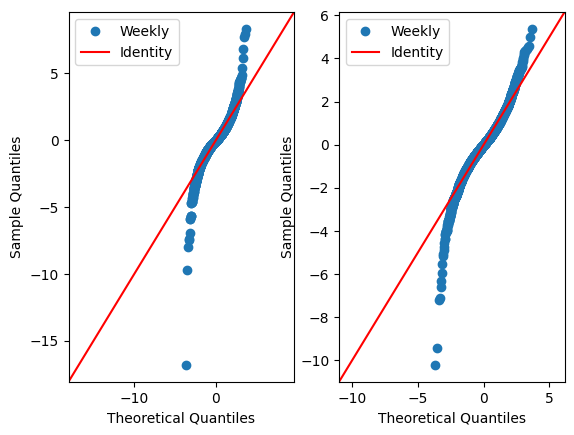

In [ ]:
"""
TEST QQ plot pour voir si les log returns suivent une loi normale

conclusion oui mais pas sur les valeurs extremes qui apparaissent plus souvent
que pour une loi normale

Le weekly semble mieux fitter
"""
fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
sm.graphics.qqplot(log_return.daily, line='45', ax=ax, fit=True)
ax.legend(["Weekly", "Identity"])

ax = fig.add_subplot(1, 2, 2)
sm.graphics.qqplot(log_return.weekly, line='45', ax=ax, fit=True)
ax.legend(["Weekly", "Identity"])

# Moving average
La std error est plus élevée que celle de la weekly, ce qui montre que ce n'est pas efficace

In [ ]:
log_return["weekly_pred"] = log_return.weekly.shift(nb_days)
log_return["weekly_error"] = log_return.weekly_pred - log_return.weekly
log_return = log_return.dropna()
log_return.describe()

daily       weekly  weekly_pred  weekly_error
count  9412.000000  9412.000000  9412.000000   9412.000000
mean      0.000869     0.004352     0.004335     -0.000017
std       0.021370     0.045186     0.045214      0.065409
min      -0.358332    -0.457496    -0.457496     -0.483857
25%      -0.009337    -0.019433    -0.019433     -0.035767
50%       0.000314     0.004161     0.004161      0.000562
75%       0.011236     0.028219     0.028219      0.036786
max       0.178692     0.247060     0.247060      0.415877

In [ ]:
fig = px.histogram(log_return, histnorm='probability')
fig.show()

In [ ]:
fig = px.line(log_return)
fig.show()

# Darts forecasting


1.   Kalmann Filter
2.   Élément de liste



Kalman filters are a method of extracting a signal from either noisy or incomplete measurements.
Denote $x_k$ the internal state at time $k$ with a state transition matrix, $A$, we have $$x_k = A x_{k-1} + q_{k-1}$$ where $$q_{k-1}\sim N(0,{Q})$$
is the observation noise.

The obtained measurement at time $k$, $y_k$ is an obseravation model, $H$, which describe how states translate to measurements times the state $x_k$, with some obseravation noise, $r_k$:
$$y_k = Hx_k + r_k$$

where $$r_k \sim N(0,R)$$ is the observation noise.

Kalman filters consist to fit a function by estimating $A,\;H,\;Q$ and $R$


In [3]:
!pip install darts
clear_output()
# https://forecastegy.com/posts/kalman-filter-for-time-series-forecasting-in-python/

In [4]:
from darts import TimeSeries
from darts.models import KalmanForecaster, ExponentialSmoothing, ARIMA, AutoARIMA, FFT, NBEATSModel, TransformerModel
from darts.utils.likelihood_models import GaussianLikelihood

from darts.metrics import mape

In [ ]:
def pdSeries2dartsSeries(series):
    resampled = series.resample('D').ffill().dropna()
    return TimeSeries.from_series(resampled, freq="D")

In [ ]:
mape(
    pdSeries2dartsSeries(log_return.weekly),
    pdSeries2dartsSeries(log_return.weekly_pred)
)

561552599417237.0

In [ ]:
def functionApply(nb_days, model=KalmanForecaster(), days2week=True):
    def aux(train):
        # Create a Darts TimeSeries object
        # log_return_ffill = train.resample('D').ffill().dropna()
        # ts = TimeSeries.from_dataframe(log_return_ffill, value_cols='daily', freq="D")
        # ts = TimeSeries.from_series(log_return_ffill, freq="D")
        ts = pdSeries2dartsSeries(train)

        # Fit the model on the training data
        fitted = model.fit(ts)

        # Predict log returns on the test data
        predictions = fitted.predict(nb_days)

        # Convert the predictions back to a DataFrame
        predictions_df = predictions.pd_dataframe()
        if days2week:
            return float(predictions_df.sum())
        else:
            return predictions.pd_series()[-1]

    return aux

In [ ]:
test = log_return.weekly[:nb_days*52+5].rolling(nb_days*52).apply(functionApply(nb_days, ARIMA(), days2week=False))
test

Date
1986-03-27         NaN
1986-03-31         NaN
1986-04-01         NaN
1986-04-02         NaN
1986-04-03         NaN
                ...   
1987-04-07   -0.032362
1987-04-08    0.069036
1987-04-09    0.043535
1987-04-10   -0.009503
1987-04-13   -0.021660
Name: weekly, Length: 265, dtype: float64

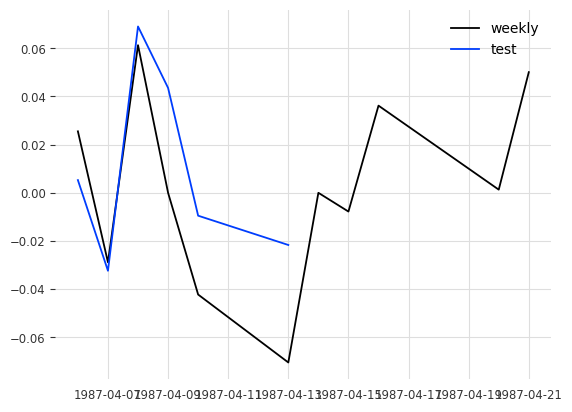

In [ ]:
plt.plot(log_return.weekly[52*nb_days-1:52*nb_days+10], label="weekly")
plt.plot(test, label="test")
plt.legend()

In [ ]:
ts = pdSeries2dartsSeries(log_return.weekly[:95])

model = TransformerModel(
        input_chunk_length=95,
        output_chunk_length=nb_days,
        likelihood=GaussianLikelihood()
)
# Fit the model on the training data
fitted = model.fit(ts)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 650   
------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Tot

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# Predict log returns on the test data
predictions = fitted.predict(5, num_samples=500)

# Convert the predictions back to a DataFrame
predictions_df = predictions.pd_dataframe()
# predictions_df

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [ ]:
predictions.quantile(0.5).pd_dataframe()

component   weekly_0.5
Date                  
1986-08-12    0.005017
1986-08-13   -0.002452
1986-08-14   -0.059942
1986-08-15   -0.098731
1986-08-16   -0.086381

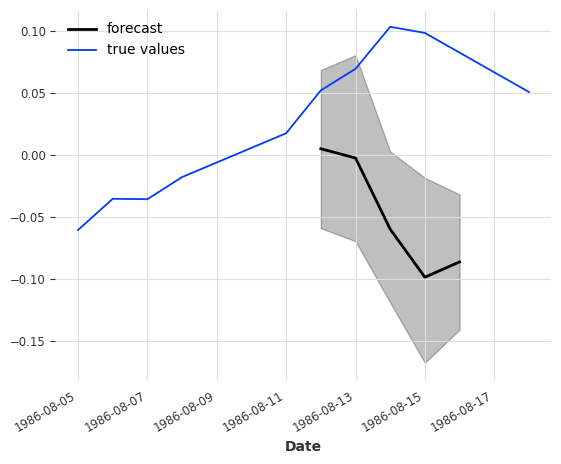

In [ ]:

predictions.plot(label="forecast", low_quantile=0.25, high_quantile=0.75)
plt.plot(log_return.weekly[90:95+5], label="true values")
plt.legend()

In [ ]:
log_return.daily[100:100+5].sum(), predictions_df.daily.sum()

(-0.025104229530604386, 0.13281445875327677)

In [ ]:
liste = [
    ("KalmanForecaster_1", KalmanForecaster(dim_x=1)),
    ("KalmanForecaster_10", KalmanForecaster(dim_x=10)),
    ("KalmanForecaster_100", KalmanForecaster(dim_x=100)),
    ("ExponentialSmoothing", ExponentialSmoothing()),
    ("ARIMA", ARIMA()),
    NBEATSModel(nb_days*52, 7)
]



log_return.daily.rolling(nb_days*52).apply(functionApply(nb_days, method))

In [ ]:
df.head()

Open      High       Low     Close  Adj Close      Volume
Date                                                                     
1986-03-13  0.088542  0.101563  0.088542  0.097222   0.060524  1031788800
1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062686   308160000
1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063767   133171200
1986-03-18  0.102431  0.103299  0.098958  0.099826   0.062145    67766400
1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061065    47894400

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [ ]:
test = df.resample('W').last()
n_forecats = len(test)


# PyPortifolioOpt
https://pypi.org/project/pyportfolioopt/

In [ ]:
!pip install pyportfolioopt
!pip install darts
clear_output()

In [ ]:
from pypfopt import EfficientFrontier, risk_models, expected_returns, CLA, \
black_litterman, BlackLittermanModel, HRPOpt, EfficientSemivariance, \
plotting, hierarchical_portfolio
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime, timedelta
from pandas_datareader import data as web
from pprint import pprint
from pypfopt import base_optimizer

In [ ]:
ticker = ['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY']
history_range = {'start': datetime(2008, 1, 1),
                 'end': datetime(2020, 10, 1)}

stock = yf.download(ticker,
                start=history_range['start'],
                end=history_range['end'])

[*********************100%***********************]  10 of 10 completed


In [ ]:
stock_close = stock.Close
stock_close

AAPL        AEE          AIG        AMD        AMZN  \
Date                                                                    
2008-01-02    6.958571  53.349998  1126.000000   7.140000    4.812500   
2008-01-03    6.961786  53.310001  1129.000000   6.770000    4.760500   
2008-01-04    6.430357  52.919998  1106.000000   6.250000    4.439500   
2008-01-07    6.344286  53.610001  1126.000000   6.080000    4.441000   
2008-01-08    6.116071  53.310001  1111.000000   6.000000    4.394000   
...                ...        ...          ...        ...         ...   
2020-09-24  108.220001  76.699997    26.480000  75.820000  150.989502   
2020-09-25  112.279999  78.209999    27.070000  78.059998  154.756500   
2020-09-28  114.959999  78.419998    27.629999  79.480003  158.702499   
2020-09-29  114.089996  79.019997    27.290001  81.769997  157.244003   
2020-09-30  115.809998  79.080002    27.530001  81.989998  157.436493   

                    BA           C         MO        MSFT         WY  
Date                                                                  
2008-01-02   86.620003  289.200012  74.930000   35.220001  71.519997  
2008-01-03   86.980003  289.299988  75.389999   35.369999  72.199997  
2008-01-04   85.820000  282.399994  74.900002   34.380001  68.620003  
2008-01-07   82.870003  282.600006  77.230003   34.610001  68.129997  
2008-01-08   79.910004  271.399994  78.320000   33.450001  66.699997  
...                ...         ...        ...         ...        ...  
2020-09-24  146.050003   42.189999  38.330002  203.190002  26.980000  
2020-09-25  156.029999   42.020000  38.270000  207.820007  27.280001  
2020-09-28  166.080002   43.340000  38.950001  209.440002  28.309999  
2020-09-29  163.600006   42.419998  38.360001  207.259995  28.049999  
2020-09-30  165.259995   43.110001  38.639999  210.330002  28.520000  

[3210 rows x 10 columns]

In [ ]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(stock_close)
S = risk_models.sample_cov(stock_close)

In [ ]:
mu

AAPL    0.247102
AEE     0.031391
AIG    -0.252808
AMD     0.211284
AMZN    0.315076
BA      0.052038
C      -0.138835
MO     -0.050678
MSFT    0.150661
WY     -0.069653
dtype: float64

In [ ]:
S

AAPL       AEE       AIG       AMD      AMZN        BA         C  \
AAPL  0.102896  0.026709  0.070494  0.075411  0.058885  0.049952  0.077184   
AEE   0.026709  0.059006  0.051504  0.037016  0.025893  0.037129  0.050313   
AIG   0.070494  0.051504  0.512809  0.106560  0.068464  0.097924  0.245820   
AMD   0.075411  0.037016  0.106560  0.386789  0.077460  0.069300  0.120709   
AMZN  0.058885  0.025893  0.068464  0.077460  0.140424  0.047955  0.075363   
BA    0.049952  0.037129  0.097924  0.069300  0.047955  0.134150  0.097131   
C     0.077184  0.050313  0.245820  0.120709  0.075363  0.097131  0.339281   
MO    0.025046  0.022957  0.041906  0.028193  0.021891  0.030974  0.035818   
MSFT  0.051316  0.032441  0.066785  0.069099  0.059589  0.050413  0.072993   
WY    0.052658  0.045912  0.107483  0.083343  0.057170  0.073350  0.115450   

            MO      MSFT        WY  
AAPL  0.025046  0.051316  0.052658  
AEE   0.022957  0.032441  0.045912  
AIG   0.041906  0.066785  0.107483  
AMD   0.028193  0.069099  0.083343  
AMZN  0.021891  0.059589  0.057170  
BA    0.030974  0.050413  0.073350  
C     0.035818  0.072993  0.115450  
MO    0.087703  0.024846  0.032335  
MSFT  0.024846  0.083872  0.052956  
WY    0.032335  0.052956  0.165936

In [ ]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
pprint(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPL', 0.46073),
             ('AEE', 0.0),
             ('AIG', 0.0),
             ('AMD', 0.0),
             ('AMZN', 0.53927),
             ('BA', 0.0),
             ('C', 0.0),
             ('MO', 0.0),
             ('MSFT', 0.0),
             ('WY', 0.0)])
Expected annual return: 28.4%
Annual volatility: 30.3%
Sharpe Ratio: 0.87


(0.2837580986667204, 0.3032153835308417, 0.8698704386147746)

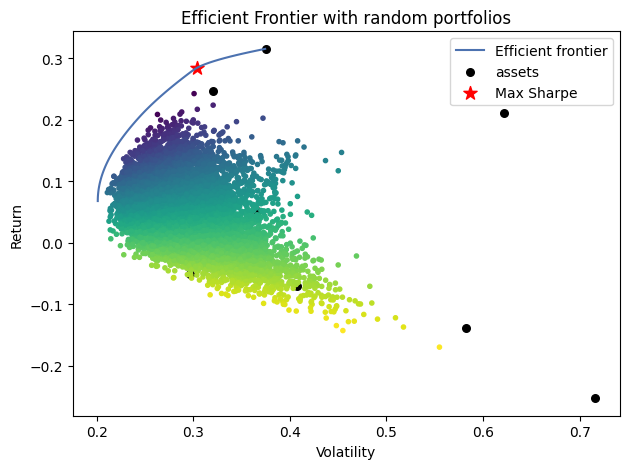

In [ ]:
fig, ax = plt.subplots()
ef = EfficientFrontier(mu, S)
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

<Axes: >

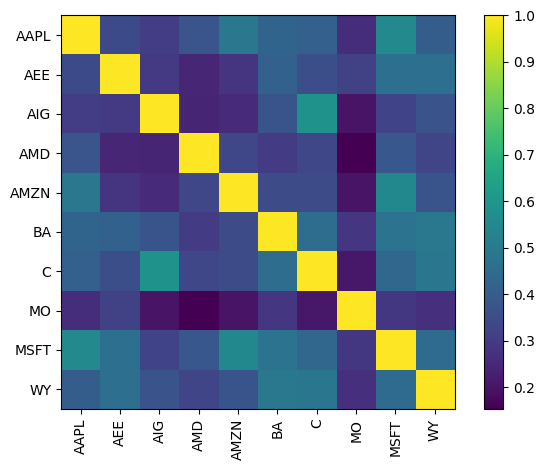

In [ ]:
plotting.plot_covariance(S, plot_correlation=True)

/usr/local/lib/python3.10/dist-packages/pypfopt/plotting.py:104: RuntimeWarning: hrp param has not been optimized.  Attempting optimization.
  warnings.warn(


<Axes: >

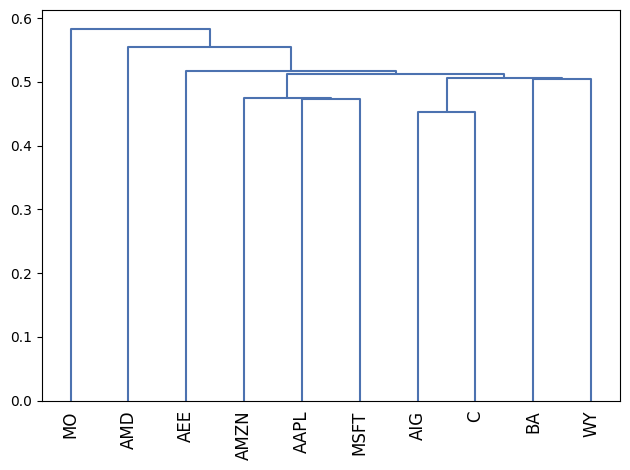

In [ ]:
hrp = HRPOpt(cov_matrix=S)
plotting.plot_dendrogram(hrp)

# Tests sur un portefeuille de 10 assets plutôt diversifié

[*********************100%***********************]  10 of 10 completed


/usr/local/lib/python3.10/dist-packages/pypfopt/plotting.py:104: RuntimeWarning: hrp param has not been optimized.  Attempting optimization.
  warnings.warn(


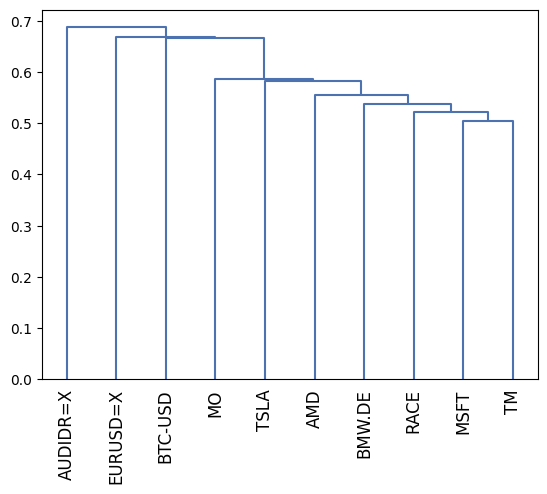

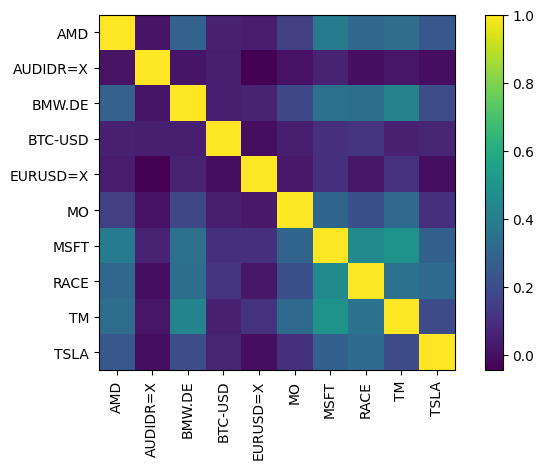

In [ ]:
ticker = ['MSFT', 'AMD','MO', "EURUSD=X", "TSLA", "BTC-USD", "TM", "RACE", "BMW.DE", "AUDIDR=X"]
history_range = {'start': datetime(2008, 1, 1),
                 'end': datetime(2020, 10, 1)}

stock = yf.download(ticker,
                start=history_range['start'],
                end=history_range['end'])
stock_close = stock.Close

fig, ax = plt.subplots()
S = risk_models.sample_cov(stock_close, frequency=5)
plotting.plot_covariance(S, plot_correlation=True)

hrp = HRPOpt(cov_matrix=S)
plotting.plot_dendrogram(hrp, ax=ax)

fig.show()

In [ ]:
# Calculate expected returns and sample covariance
stock_close = stock_close.dropna()
stock_close

AMD      AUDIDR=X     BMW.DE       BTC-USD  EURUSD=X  \
Date                                                                     
2015-10-21   2.100000   9796.099609  88.000000    266.272003  1.135396   
2015-10-22   2.140000      9.890200  90.349998    274.023010  1.134803   
2015-10-23   2.210000   9909.700195  93.290001    276.496002  1.108095   
2015-10-26   2.150000   9823.099609  92.910004    285.299988  1.102038   
2015-10-27   2.150000   9838.099609  92.379997    293.787994  1.106599   
...               ...           ...        ...           ...       ...   
2020-09-24  75.820000  10461.125977  60.639999  10760.066406  1.165854   
2020-09-25  78.059998  10471.890625  59.060001  10692.716797  1.167324   
2020-09-28  79.480003  10444.202148  61.730000  10709.652344  1.163535   
2020-09-29  81.769997  10523.501953  62.000000  10844.640625  1.167883   
2020-09-30  81.989998  10599.733398  61.990002  10784.491211  1.174205   

                   MO        MSFT        RACE          TM        TSLA  
Date                                                                   
2015-10-21  59.840000   47.200001   55.000000  123.699997   14.006000  
2015-10-22  61.400002   48.029999   56.750000  125.230003   14.114667  
2015-10-23  61.049999   52.869999   56.380001  125.739998   13.939333  
2015-10-26  61.400002   54.250000   55.020000  125.330002   14.350667  
2015-10-27  61.060001   53.689999   53.849998  124.830002   14.023333  
...               ...         ...         ...         ...         ...  
2020-09-24  38.330002  203.190002  182.830002  131.850006  129.263336  
2020-09-25  38.270000  207.820007  181.250000  132.970001  135.779999  
2020-09-28  38.950001  209.440002  183.279999  136.009995  140.399994  
2020-09-29  38.360001  207.259995  182.350006  134.250000  139.690002  
2020-09-30  38.639999  210.330002  184.089996  132.440002  143.003326  

[1218 rows x 10 columns]

In [ ]:
weekly_returns = (
    np.exp(
        expected_returns.returns_from_prices(
            stock_close,
            log_returns=True
        ).rolling(5).sum()
    )-1
).dropna()
weekly_returns

AMD    AUDIDR=X    BMW.DE   BTC-USD  EURUSD=X        MO  \
Date                                                                       
2015-10-28  0.038095    0.002818  0.056477  0.144011 -0.027913  0.026738   
2015-10-29 -0.004673  981.851706  0.033094  0.145360 -0.036929  0.002117   
2015-10-30 -0.040724   -0.028084  0.000750  0.186328 -0.007861 -0.009500   
2015-11-02  0.018605   -0.000733  0.015606  0.265997  0.000507 -0.014658   
2015-11-03  0.060465   -0.007166  0.012882  0.373157 -0.004517 -0.052571   
...              ...         ...       ...       ...       ...       ...   
2020-09-24 -0.009536   -0.032425 -0.064342 -0.017255 -0.012276 -0.061919   
2020-09-25  0.041772   -0.033529 -0.073423 -0.023013 -0.014767 -0.039408   
2020-09-28  0.019759   -0.026952  0.020499  0.023646 -0.017744  0.003349   
2020-09-29  0.052381   -0.009590  0.023440  0.029054 -0.007577 -0.004929   
2020-09-30  0.097150    0.002215  0.016896  0.052537  0.002877  0.018719   

                MSFT      RACE        TM      TSLA  
Date                                                
2015-10-28  0.143644 -0.056909  0.021504  0.013661  
2015-10-29  0.110972 -0.100969 -0.015891 -0.000425  
2015-10-30 -0.004350 -0.105534 -0.024813 -0.010330  
2015-11-02 -0.018617 -0.035260 -0.016197 -0.006829  
2015-11-03  0.008568 -0.027298 -0.011536 -0.009508  
...              ...       ...       ...       ...  
2020-09-24  0.001380 -0.038445 -0.023333 -0.084170  
2020-09-25  0.037078 -0.035494 -0.009534 -0.078729  
2020-09-28  0.034067 -0.004454  0.036504 -0.062729  
2020-09-29 -0.000771 -0.005183  0.015123 -0.012163  
2020-09-30  0.048557  0.013823 -0.006377  0.127905  

[1213 rows x 10 columns]

In [ ]:
weekly_true_returns = weekly_returns.shift(-5)
weekly_true_returns

AMD  AUDIDR=X    BMW.DE   BTC-USD  EURUSD=X        MO  \
Date                                                                     
2015-10-28  0.009174 -0.008744 -0.005593  0.351079 -0.006622 -0.055501   
2015-10-29  0.032864 -0.006388 -0.006000  0.230995 -0.005575 -0.056558   
2015-10-30  0.014151  0.001495  0.028599  0.141625 -0.009992 -0.055896   
2015-11-02 -0.036530 -0.027343  0.006359  0.052792 -0.026533 -0.056529   
2015-11-03 -0.114035 -0.028328  0.025222 -0.165085 -0.023284 -0.018323   
...              ...       ...       ...       ...       ...       ...   
2020-09-24       NaN       NaN       NaN       NaN       NaN       NaN   
2020-09-25       NaN       NaN       NaN       NaN       NaN       NaN   
2020-09-28       NaN       NaN       NaN       NaN       NaN       NaN   
2020-09-29       NaN       NaN       NaN       NaN       NaN       NaN   
2020-09-30       NaN       NaN       NaN       NaN       NaN       NaN   

                MSFT      RACE        TM      TSLA  
Date                                                
2015-10-28  0.007781  0.030268 -0.022159  0.087669  
2015-10-29  0.019115  0.014112  0.013145  0.095166  
2015-10-30  0.043313  0.039659  0.002447  0.122892  
2015-11-02  0.017280  0.002261 -0.008759  0.053978  
2015-11-03 -0.011819  0.030928  0.001621  0.039117  
...              ...       ...       ...       ...  
2020-09-24       NaN       NaN       NaN       NaN  
2020-09-25       NaN       NaN       NaN       NaN  
2020-09-28       NaN       NaN       NaN       NaN  
2020-09-29       NaN       NaN       NaN       NaN  
2020-09-30       NaN       NaN       NaN       NaN  

[1213 rows x 10 columns]

In [ ]:
jour_j = np.random.choice(stock_close.index[5*51:-5])
td_1Y = np.timedelta64(7*51, "D")
td_7D = np.timedelta64(7, "D")
dico = {"jour_j": jour_j}

mu = weekly_returns.loc[jour_j]
S = risk_models.sample_cov(
    stock_close.loc[jour_j-td_1Y:jour_j],
    frequency=5
)
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
weight_sum = np.abs(list(cleaned_weights.values())).sum()
for key in cleaned_weights.keys():
    cleaned_weights[key] = cleaned_weights[key]/weight_sum
res = base_optimizer.portfolio_performance(
    cleaned_weights, mu, S, risk_free_rate=0.02
)
dico.update(
    from_res_to_dict(res, "est.-")
)

true_mu = weekly_returns.loc[jour_j+td_7D]
true_S = risk_models.sample_cov(
    stock_close.loc[jour_j:jour_j+td_7D],
    frequency=5
)
if np.abs(mu).max() > 1 or np.abs(true_mu).max() > 1:
    raise Exception("Rendement sur une semaine abherrant")

res = base_optimizer.portfolio_performance(
    cleaned_weights, true_mu, true_S, risk_free_rate=0.02
)
dico.update(
    from_res_to_dict(res, "real-")
)

In [ ]:
dico

{'jour_j': numpy.datetime64('2017-06-22T00:00:00.000000000'),
 'est.-return': 0.08148146336055953,
 'est.-vol': 0.025540944478165132,
 'est.-sharpe': 2.407172663999165,
 'real-return': -0.039886100547863505,
 'real-vol': 0.014368392844346562,
 'real-sharpe': -4.167905290216678}

In [ ]:
np.abs(list(cleaned_weights.values())).sum()

1.0

In [ ]:


def from_res_to_dict(res, pre=''):
    dico = {
        pre+"return": res[0],
        pre+"vol": res[1],
        pre+"sharpe": res[2]
    }
    return dico

def get_result_from_random_test():

    while True:
        try:
            jour_j = np.random.choice(stock_close.index[5*51:-5])
            td_1Y = np.timedelta64(7*51, "D")
            td_7D = np.timedelta64(7, "D")
            dico = {"jour_j": jour_j}

            mu = weekly_returns.loc[jour_j]
            S = risk_models.sample_cov(
                stock_close.loc[jour_j-td_1Y:jour_j],
                frequency=5
            )
            # Optimize for maximal Sharpe ratio
            ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
            raw_weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
            weight_sum = np.abs(list(cleaned_weights.values())).sum()
            for key in cleaned_weights.keys():
                cleaned_weights[key] = cleaned_weights[key]/weight_sum
            res = base_optimizer.portfolio_performance(
                cleaned_weights, mu, S, risk_free_rate=0.02
            )
            dico.update(
                from_res_to_dict(res, "est.-")
            )

            true_mu = weekly_returns.loc[jour_j+td_7D]
            true_S = risk_models.sample_cov(
                stock_close.loc[jour_j:jour_j+td_7D],
                frequency=5
            )
            if np.abs(mu).max() > 1 or np.abs(true_mu).max() > 1:
                raise Exception("Rendement sur une semaine abherrant")

            res = base_optimizer.portfolio_performance(
                cleaned_weights, true_mu, true_S, risk_free_rate=0.02
            )
            dico.update(
                from_res_to_dict(res, "real-")
            )
            for key in cleaned_weights.keys():
                cleaned_weights[key] = 1/len(true_mu)
            res = base_optimizer.portfolio_performance(
                cleaned_weights, true_mu, true_S, risk_free_rate=0.02
            )
            dico.update(
                from_res_to_dict(res, "equal-")
            )
            return dico
        except:
            pass

get_result_from_random_test()


{'jour_j': numpy.datetime64('2018-09-07T00:00:00.000000000'),
 'est.-return': 0.04961187011782371,
 'est.-vol': 0.012954900999056955,
 'est.-sharpe': 2.2857658364181472,
 'real-return': 0.014146783090734536,
 'real-vol': 0.03126386773625273,
 'real-sharpe': -0.1872198589964681,
 'equal-return': 0.04882128744614836,
 'equal-vol': 0.02001127892526933,
 'equal-sharpe': 1.440252147490391}

In [ ]:
data = []
for i in range(100):
    data.append(
        get_result_from_random_test()
    )

df = pd.DataFrame.from_records(data)

In [ ]:
np.log(df[["est.-return", "real-return", "equal-return"]]+1).describe()

est.-return  real-return  equal-return
count   100.000000   100.000000    100.000000
mean      0.037538     0.001818      0.006742
std       0.017986     0.017592      0.019550
min       0.013833    -0.037308     -0.055536
25%       0.024624    -0.007953     -0.005383
50%       0.033515    -0.000132      0.009297
75%       0.044123     0.009041      0.022481
max       0.101326     0.067168      0.042621

In [ ]:
df.describe()

est.-return    est.-vol  est.-sharpe  real-return    real-vol  \
count   100.000000  100.000000   100.000000   100.000000  100.000000   
mean      0.038419    0.013664     1.232127     0.001974    0.014078   
std       0.018916    0.003778     1.087946     0.017722    0.008714   
min       0.013929    0.007206    -0.625710    -0.036620    0.002394   
25%       0.024929    0.010797     0.383195    -0.007922    0.008167   
50%       0.034083    0.012999     1.136913    -0.000132    0.012283   
75%       0.045111    0.015676     1.841111     0.009082    0.016970   
max       0.106637    0.027821     5.431842     0.069475    0.049990   

       real-sharpe  equal-return   equal-vol  equal-sharpe  
count   100.000000    100.000000  100.000000    100.000000  
mean     -1.902838      0.006954    1.032897     -0.723283  
std       1.846195      0.019595   10.035703      1.299467  
min      -9.441957     -0.054022    0.003137     -7.030293  
25%      -2.794536     -0.005368    0.013023     -1.406976  
50%      -1.728833      0.009341    0.018420     -0.534757  
75%      -0.829505      0.022736    0.025163      0.125641  
max       1.137937      0.043542  100.382306      1.292888